In [29]:
pip install tensorflow-datasets 

Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [31]:
# loading the dataset
data, data_info = tfds.load('malaria',as_supervised=True,split='train',with_info=True,shuffle_files=True)

In [32]:
data_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Atharva Darke\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      im

In [33]:
list(data.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

In [34]:
# Splitting the dataset:-
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1


In [35]:
def split(dataset,TRAIN_RATIO,TEST_RATIO,VAL_RATIO):
    DATA_SIZE = len(data)
    train_dataset = data.take(int(TRAIN_RATIO*DATA_SIZE))
    test_ = data.skip(int(TRAIN_RATIO*DATA_SIZE))
    test_dataset = test_.take(int(TEST_RATIO*DATA_SIZE))
    valid_dataset = test_.skip(int(TEST_RATIO*DATA_SIZE))
    return train_dataset,test_dataset,valid_dataset

In [36]:
train,test,valid = split(data,TRAIN_RATIO,TEST_RATIO,VAL_RATIO)

In [37]:
print(len(data),len(train),len(test),len(valid))

27558 22046 2755 2757


In [38]:
print(list(train.take(1).as_numpy_iterator()),list(test.take(1).as_numpy_iterator()),list(valid.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

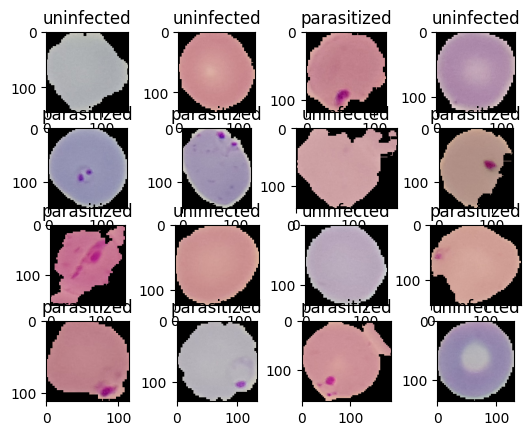

In [39]:
# visualizing the data
import matplotlib.pyplot as plt

for i,(image,label) in enumerate(train.take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(data_info.features['label'].int2str(label))

In [40]:
# Preprocessing:

def preprocess(image,label):
    image_resized = tf.image.resize(image,size=(224,224),method='bilinear')/255.0
    return image_resized,label

In [41]:
train = train.map(preprocess)
valid = valid.map(preprocess)
test = test.map(preprocess)

train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [43]:
data_info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=2)

In [44]:
for image,label in test.take(1):
    print(image)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [45]:
for item in train.take(1):
    print(type(item))

<class 'tuple'>


In [46]:
for image,label in train.take(1):
    print(image.shape,label.shape)

(32, 224, 224, 3) (32,)


In [47]:
model = tf.keras.Sequential([
                            InputLayer(shape=(224,224,3)),
    
                            Conv2D(filters=6,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=(2,2),strides=2),

                            Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=(2,2),strides=2),

                            Flatten(),

                            layers.Dense(100,activation='relu'),
                            BatchNormalization(),

                            layers.Dense(10,activation='relu'),
                            BatchNormalization(),
                            layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [48]:
len(valid)

87

In [49]:
list(data.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

In [50]:
early_call = EarlyStopping(min_delta=0.01,verbose=1,patience=10)

In [51]:
#
model.compile(optimizer=Adam(learning_rate=0.01),metrics=['accuracy'],loss=BinaryCrossentropy())

In [52]:
history = model.fit(train,validation_data=valid,batch_size=50,epochs=5,verbose=1, callbacks=[early_call])

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 196s 279ms/step - accuracy: 0.7492 - loss: 0.4865 - val_accuracy: 0.7109 - val_loss: 0.4881
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 188s 273ms/step - accuracy: 0.9326 - loss: 0.1930 - val_accuracy: 0.9249 - val_loss: 0.2707
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 189s 274ms/step - accuracy: 0.9437 - loss: 0.1709 - val_accuracy: 0.9431 - val_loss: 0.1750
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 189s 275ms/step - accuracy: 0.9492 - loss: 0.1552 - val_accuracy: 0.9420 - val_loss: 0.1616
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 187s 272ms/step - accuracy: 0.9502 - loss: 0.1496 - val_accuracy: 0.9452 - val_loss: 0.8696


In [53]:
eval = model.evaluate(test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9539 - loss: 0.1600


In [54]:
preds = model.predict(test.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [55]:
model.save('lenet_model.h5')
model.save('lenet_model.keras')

In [56]:
def diagnosed_or_not(x):
    if x>=0.5:
        return str("diagnosed")

    else:
        return str("not_diagnosed")
    


    

In [57]:
diagnosed_or_not(preds)

'diagnosed'

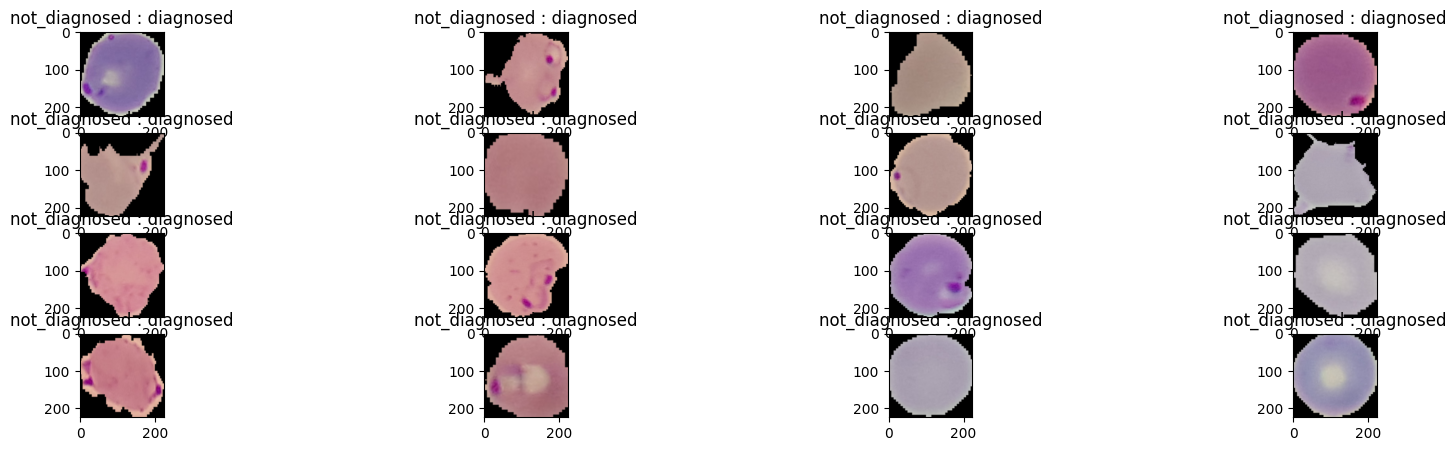

In [58]:
plt.figure(figsize=(20,5))
for i,(image,label) in enumerate(test.take(1)):
    for j in range(16):
        axes = plt.subplot(4,4,j+1)
        plt.imshow(image[j])
        plt.title(str(diagnosed_or_not(label.numpy()[0])) +" : "+ str(diagnosed_or_not(preds)))
    # print(image[0][0])

Functional API

In [59]:
funct_input = Input((224,224,3),name='input_img')

x = Conv2D(filters=6,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu')(funct_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2),strides=2)(x)

x = Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2),strides=2)(x)

x = Flatten()(x)

x = layers.Dense(100,activation='relu')(x)
x = BatchNormalization()(x)

x = layers.Dense(10,activation='relu')(x)
x = BatchNormalization()(x)
funct_output = layers.Dense(1,activation='sigmoid')(x)

lenet_model = Model(funct_input,funct_output,name='lenet_model')
lenet_model.summary()

Model: "lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)               │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)